In [1]:
import torch
from utils import LQR_2D_true_solution, out_put, LQR_1D_true_solution, l_2_compute_1D_Q, l_2_compute_1D_V, true_V_eval_2D
from bases import bases_poly, d_bases_poly, sec_bases_poly, bases_2d, bases_poly_simp, d_bases_poly_simp, sec_bases_poly_simp, bases_2d_simp, bases_poly_2D, bases_poly_2D_s_a, d_bases_poly_2D, bases_poly_2D_simp, d_bases_poly_2D_simp, sec_d_bases_poly_2D, sec_d_bases_poly_2D_simp, bases_poly_2D_s_a_simp
from main_phibe import phibe_finder_1D_LQR, phibe_finder_2D_LQR
from main_RL import RL_finder_1D_LQR, RL_finder_2D_LQR
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

In [2]:
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

In [3]:
def reward(traj_mat, act_mat):
    # traj_mat shape: (m, I, dim)
    # act_mat shape: (m, I, dim)
    # output shape: (m, I, 1)
    r_1 = torch.einsum("ijk,kl,ijl->ij", traj_mat, Q, traj_mat)
    r_2 = torch.einsum("ijk,kl,ijl->ij", act_mat, R, act_mat)
    return (- r_1 - r_2).unsqueeze(-1)

In [4]:
beta = 1e-2
A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 1.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [5]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(25.0000)


In [6]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(36.7500)


In [7]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [8]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.0841, -0.0793],
        [-0.0793, -0.0841]])
tensor([[0.],
        [0.]])
tensor([-41.1219,  -0.2056,  -0.1724,  -0.2056])
tensor([-230.1912,   -1.5498,    1.3084,   -0.7521])


In [10]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 50
simp_basis = False
deterministic = True
b_val_phibe, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


In [11]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 50
simple_basis = False
b_val_RL, V_exact_dist_RL_1 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:35<00:00,  1.17s/it]


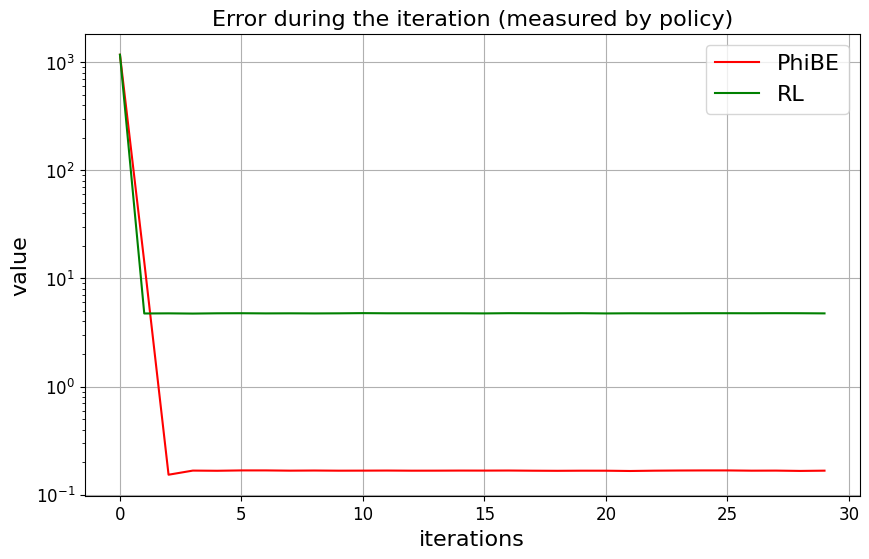

In [12]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_1[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [13]:
beta = 0.01
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
A = 1 * torch.tensor([[-0.9, 0.85], [0.85, -0.88]])
B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 1.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [14]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(2306.0366)


In [15]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(36.7500)


In [21]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [22]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.5627, -0.4219],
        [-0.4264, -0.5692]])
tensor([[0.],
        [0.]])
tensor([-113.1610,   -0.5669,   -1.0749,   -0.5647])
tensor([-917.3075,   -3.9021,   -8.8012,   -5.2709])


In [23]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = False
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


In [24]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simple_basis = False
b_val_RL_2, V_exact_dist_RL_2 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:  43%|████▎     | 13/30 [00:16<00:20,  1.19s/it]

infeasibility detected


Running RL method:  90%|█████████ | 27/30 [00:33<00:03,  1.20s/it]

infeasibility detected


Running RL method: 100%|██████████| 30/30 [00:36<00:00,  1.23s/it]


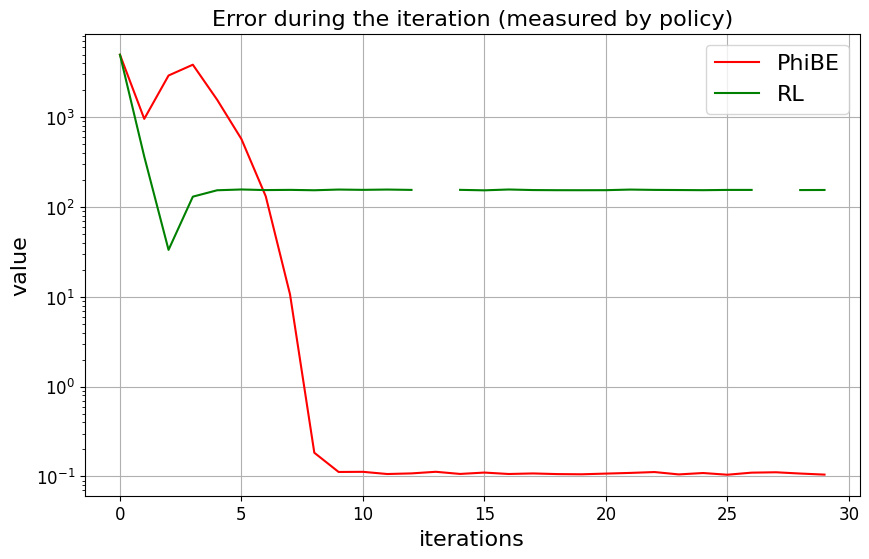

In [25]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_2[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [28]:
beta = 0.01
A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = 1 * torch.tensor([[-0.9, 0.85], [0.85, -0.88]])
# B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 1.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [29]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(25.0000)


In [30]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(102019.1848)


In [102]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + 0.5 * torch.randn(2, 2)
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [103]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.1102, -0.1102],
        [-0.1102, -0.1102]])
tensor([[0.],
        [0.]])
tensor([-34.9126,  -0.1746,  -0.3412,  -0.1746])
tensor([-1969.9716,    -5.0560,    16.0891,   -14.6437])


In [47]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = False
deterministic = True
b_val_phibe_3, V_exact_dist_phibe_3, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin:  13%|█▎        | 4/30 [00:06<00:41,  1.58s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  23%|██▎       | 7/30 [00:10<00:34,  1.52s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  27%|██▋       | 8/30 [00:12<00:32,  1.50s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  33%|███▎      | 10/30 [00:15<00:30,  1.52s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  40%|████      | 12/30 [00:18<00:27,  1.50s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  47%|████▋     | 14/30 [00:21<00:23,  1.47s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  57%|█████▋    | 17/30 [00:26<00:20,  1.60s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  60%|██████    | 18/30 [00:27<00:18,  1.55s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  63%|██████▎   | 19/30 [00:29<00:16,  1.53s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  67%|██████▋   | 20/30 [00:30<00:15,  1.55s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  70%|███████   | 21/30 [00:32<00:14,  1.56s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  97%|█████████▋| 29/30 [00:44<00:01,  1.52s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:45<00:00,  1.53s/it]


In [48]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simple_basis = False
b_val_RL_3, V_exact_dist_RL_3 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:   7%|▋         | 2/30 [00:02<00:40,  1.45s/it]

infeasibility detected


Running RL method:  10%|█         | 3/30 [00:04<00:37,  1.40s/it]

infeasibility detected


Running RL method:  67%|██████▋   | 20/30 [00:25<00:12,  1.25s/it]

infeasibility detected


Running RL method:  73%|███████▎  | 22/30 [00:27<00:09,  1.22s/it]

infeasibility detected


Running RL method:  87%|████████▋ | 26/30 [00:32<00:04,  1.21s/it]

infeasibility detected


Running RL method: 100%|██████████| 30/30 [00:37<00:00,  1.25s/it]


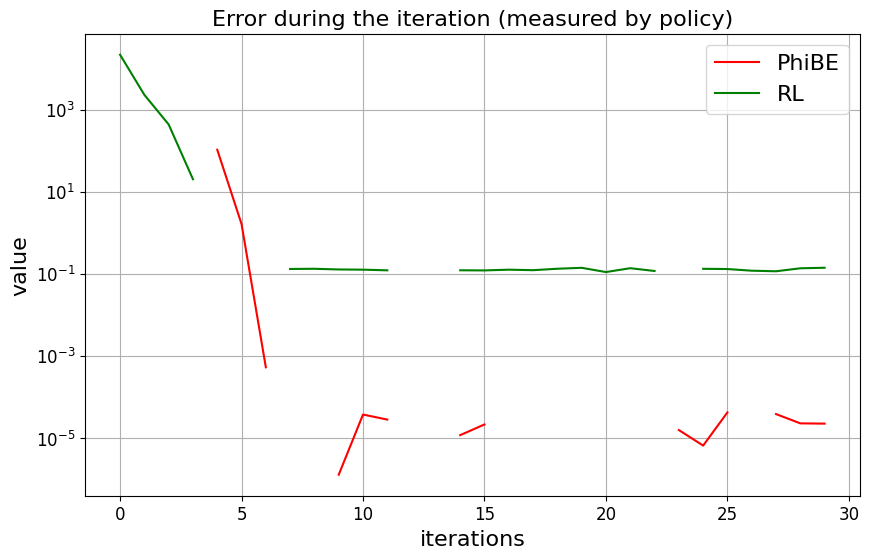

In [35]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_3[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_3[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [104]:
beta = 0.01
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
A = 1 * torch.tensor([[0.9, 0.899], [0.899, 0.88]])
B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 1.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [105]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(10751.9915)


In [106]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(36.7500)


In [120]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [121]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-1.6555, -1.4797],
        [-1.4665, -1.6365]])
tensor([[0.],
        [0.]])
tensor([-351.0162,   -1.7519,   -3.4410,   -1.7583])
tensor([-357.8527,   -1.7659,   -3.3899,   -1.8127])


In [125]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = False
deterministic = True
b_val_phibe_4, V_exact_dist_phibe_4, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin:   7%|▋         | 2/30 [00:02<00:40,  1.45s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  33%|███▎      | 10/30 [00:14<00:27,  1.39s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  40%|████      | 12/30 [00:16<00:24,  1.37s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  53%|█████▎    | 16/30 [00:22<00:19,  1.36s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


In [126]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simple_basis = False
b_val_RL_4, V_exact_dist_RL_4 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:  10%|█         | 3/30 [00:03<00:31,  1.16s/it]

infeasibility detected


Running RL method:  20%|██        | 6/30 [00:06<00:26,  1.12s/it]

infeasibility detected


Running RL method:  73%|███████▎  | 22/30 [00:24<00:09,  1.13s/it]

infeasibility detected


Running RL method: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


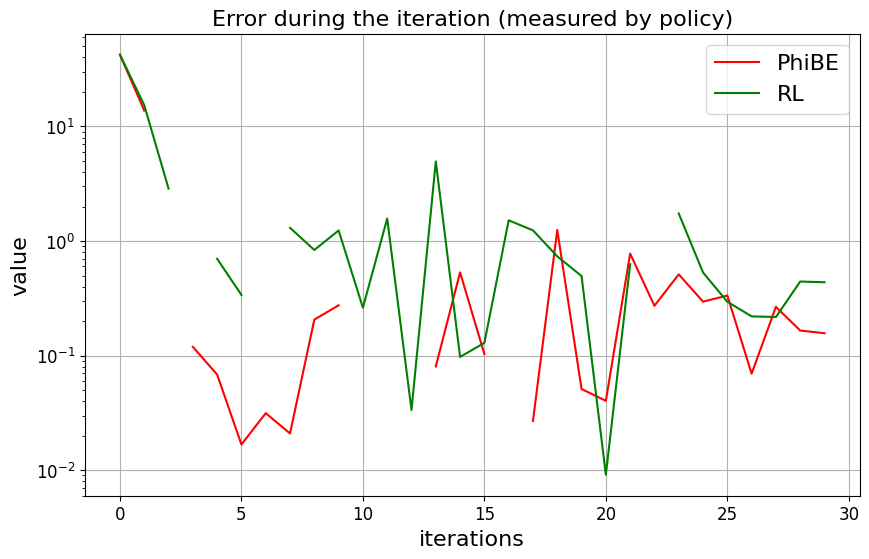

In [127]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_4[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_4[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [128]:
b_val_phibe_4

[tensor([[-1.6733, -1.4362],
         [-0.6171, -2.0628]]),
 tensor([[-1.8670, -1.3725],
         [-1.2797, -1.7295]]),
 tensor([[-1.7169, -1.4405],
         [-1.4070, -1.6658]]),
 tensor([[-1.6687, -1.4725],
         [-1.4581, -1.6454]]),
 tensor([[-1.6631, -1.4836],
         [-1.4744, -1.6473]]),
 tensor([[-1.6569, -1.4784],
         [-1.4687, -1.6404]]),
 tensor([[-1.6591, -1.4829],
         [-1.4670, -1.6338]]),
 tensor([[-1.6572, -1.4808],
         [-1.4656, -1.6328]]),
 tensor([[-1.6680, -1.4901],
         [-1.4686, -1.6346]]),
 tensor([[-1.6710, -1.4835],
         [-1.4595, -1.6340]]),
 tensor([[-1.6439, -1.4700],
         [-1.4703, -1.6418]]),
 tensor([[-1.6488, -1.4706],
         [-1.4779, -1.6567]]),
 tensor([[-1.6413, -1.4689],
         [-1.4885, -1.6669]]),
 tensor([[-1.6652, -1.4823],
         [-1.4728, -1.6490]]),
 tensor([[-1.6425, -1.4682],
         [-1.4719, -1.6454]]),
 tensor([[-1.6585, -1.4810],
         [-1.4748, -1.6470]]),
 tensor([[-1.6561, -1.4835],
         [-